# Road Safety Analysis

## Objectives
This report aims to help bring major incidents out from their hiding place amidst the accident data of 2020, so that they can be understood and hopefully neutralized, by achieving four objectives:
    
1. Build a distinct profile of major incidents in general
2. Determine the specific day of the week and time of day where most major incidents happen, and uncover any distinctive patterns at this time
3. Establish the most relevant features that can be used to predict major incidents
4. Present recommendations that could help the planning team reduce major incidents

## The data
The reporting department have been collecting data on every accident that is reported. They've included this along with a lookup file for 2020's accidents.

*Published by the department for transport. https://data.gov.uk/dataset/road-accidents-safety-data* 
*Contains public sector information licensed under the Open Government Licence v3.0.*

In [2]:
# Import libraries to be used
import warnings
warnings.filterwarnings('ignore')

import sys
!{sys.executable} -m pip install geopandas

'c:\Users\My' is not recognized as an internal or external command,
operable program or batch file.


In [61]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt; plt.style.use('seaborn-whitegrid')
import seaborn as sns
from datetime import date
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
from matplotlib.gridspec import GridSpec

In [4]:
# Import data
accidents = pd.read_csv(r'M:/RoadSafety/accident.csv')
accidents.head()

,accident_index,accident_year,accident_reference,longitude,latitude,accident_severity,number_of_vehicles,number_of_casualties,date,day_of_week,...,second_road_class,second_road_number,pedestrian_crossing_human_control,pedestrian_crossing_physical_facilities,light_conditions,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area
0,2020010219808,2020,10219808,-0.254001,51.462262,3,1,1,04/02/2020,3,...,6,0,9,9,1,9,9,0,0,1
1,2020010220496,2020,10220496,-0.139253,51.470327,3,1,2,27/04/2020,2,...,6,0,0,4,1,1,1,0,0,1
2,2020010228005,2020,10228005,-0.178719,51.529614,3,1,1,01/01/2020,4,...,6,0,0,0,4,1,2,0,0,1
3,2020010228006,2020,10228006,-0.001683,51.541210,2,1,1,01/01/2020,4,...,6,0,0,4,4,1,1,0,0,1
4,2020010228011,2020,10228011,-0.137592,51.515704,3,1,2,01/01/2020,4,...,5,0,0,0,4,1,1,0,0,1


In [5]:
# Import lookup table
lookup = pd.read_csv(r'M:/RoadSafety/LookupTable.csv')
lookup.head()

,table,field name,code/format,label,note
0,Accident,accident_index,NaN,NaN,unique value for each accident. The accident_i...
1,Accident,accident_year,NaN,NaN,NaN
2,Accident,accident_reference,NaN,NaN,In year id used by the police to reference a c...
3,Accident,longitude,NaN,NaN,Null if not known
4,Accident,Latitude,NaN,NaN,Null if not known


## Prepare
- Prepare the data for analysis
- Develop some visualization tools to help identify patterns in major incidents 

## Wrangle Data
- Check for any missing entries
- A few records (14) seem to contain missing latitude and longitude entries. These accidents can be dropped from data

Some next step:
-	Date and time fields are converted to timestamps
-	Month and Hour fields are extracted from said timestamps
-	Major incidents are labelled 1, non-major 0
-	Categorical features are identified, and their data type changed accordingly
-	Lists of numerical and categorical predictors are prepared


In [6]:
# Check for missing values and data types
accidents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91199 entries, 0 to 91198
Data columns (total 27 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   accident_index                           91199 non-null  object 
 1   accident_year                            91199 non-null  int64  
 2   accident_reference                       91199 non-null  object 
 3   longitude                                91185 non-null  float64
 4   latitude                                 91185 non-null  float64
 5   accident_severity                        91199 non-null  int64  
 6   number_of_vehicles                       91199 non-null  int64  
 7   number_of_casualties                     91199 non-null  int64  
 8   date                                     91199 non-null  object 
 9   day_of_week                              91199 non-null  int64  
 10  time                                     91199

In [7]:
# Check records with null entries
accidents[accidents.isnull().any(axis=1)]

,accident_index,accident_year,accident_reference,longitude,latitude,accident_severity,number_of_vehicles,number_of_casualties,date,day_of_week,...,second_road_class,second_road_number,pedestrian_crossing_human_control,pedestrian_crossing_physical_facilities,light_conditions,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area
25520,2020052002442,2020,052002442,NaN,NaN,2,2,1,26/11/2020,5,...,6,0,0,0,1,1,1,0,0,3
29452,2020070769852,2020,070769852,NaN,NaN,3,2,1,19/12/2020,7,...,6,0,0,0,1,1,1,0,0,3
32689,2020122001194,2020,122001194,NaN,NaN,3,2,2,30/09/2020,4,...,6,0,0,0,1,2,2,0,0,3
33578,2020137330369,2020,137330369,NaN,NaN,3,2,1,03/03/2020,3,...,3,642,0,0,1,1,1,0,0,3
81252,2020522005114,2020,522005114,NaN,NaN,3,3,2,29/05/2020,6,...,3,3033,0,0,7,1,1,0,0,3
86437,2020622001016,2020,622001016,NaN,NaN,3,2,1,13/11/2020,6,...,3,4161,0,5,4,1,1,0,0,3
86642,202063A017520,2020,63A017520,NaN,NaN,3,2,1,26/02/2020,4,...,6,0,0,0,1,9,-1,0,0,3
86651,202063A018920,2020,63A018920,NaN,NaN,3,2,1,27/02/2020,5,...,6,0,0,0,1,9,1,0,0,3
86668,202063A025020,2020,63A025020,NaN,NaN,3,2,1,12/02/2020,4,...,6,0,0,0,1,2,2,0,0,3
86705,202063A035620,2020,63A035620,NaN,NaN,3,1,1,10/06/2020,4,...,6,0,0,0,1,1,1,0,0,3


In [8]:
# Drop records with null entries
original_rows = accidents.shape[0]
accidents.dropna(inplace=True)
print('Dropped {} records with null entries'.format(original_rows - accidents.shape[0]))

Dropped 14 records with null entries


In [9]:
# Check for duplicates
accidents.duplicated().any()

False

In [10]:
# Convert date and time to timestamp
accidents['time_stamp'] = accidents['date'] + ' ' + accidents['time']
accidents['time_stamp'] = pd.to_datetime(accidents['time_stamp'], format='%d/%m/%Y %H:%M')

In [11]:
# Extract month and hour from timestamp
accidents['month'] = accidents['time_stamp'].dt.month
accidents['hour'] = accidents['time_stamp'].dt.hour

In [12]:
# Label major incidents
accidents['major_incident'] = [1 if (i==1)&(j>=3) else 0 \
                               for i, j in zip(accidents['accident_severity'], \
                                               accidents['number_of_casualties'])]

In [13]:
# List categorical features
categorical = list(accidents.select_dtypes(include=['int64']).columns)
categorical.remove('number_of_vehicles')
categorical.remove('number_of_casualties')

In [14]:
# Convert feature type to categorical
accidents[categorical] = accidents[categorical].astype('category')

In [15]:
# Sort data in chronological order
accidents = accidents.sort_values(['time_stamp'], ascending=True, ignore_index=True)

In [16]:
# List all predictors per type
num_predictors = ['longitude', 'latitude', 'number_of_vehicles', 'number_of_casualties']
cat_predictors = ['day_of_week', 'first_road_class', 'road_type', 'speed_limit', \
                  'junction_detail', 'junction_control', 'second_road_class', \
                  'pedestrian_crossing_human_control', 'pedestrian_crossing_physical_facilities', \
                  'light_conditions', 'weather_conditions', 'road_surface_conditions', \
                  'special_conditions_at_site', 'carriageway_hazards', 'urban_or_rural_area', \
                  'month', 'hour']

In [17]:
# Create labels for categorical features
labels_1 = lookup.drop(['table','note'], axis=1).dropna()
labels_2 = pd.DataFrame({'field name': ['month' for i in range(1,13)], \
                       'code/format': [str(i) for i in range(1,13)], \
                       'label': ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', \
                                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']})

labels = pd.concat([labels_1, labels_2], ignore_index=True, axis=0)

## Developing data visualization tools
Some following things will be done in this part:
-	Data subsets with major and non-major incidents
-	Calculation of time between accidents
-	Specific statistics for major and non-major incidents
-	A function to plot said statistics as plain text
-	A function to plot accident locations in the United Kingdom
-	A function to plot average statistics per month
-	A function to generate distribution of accidents and casualties per category
-	A function to plot said distributions

In [18]:
# Create subgroups of major and non-major incidents
major_incidents = accidents[accidents['major_incident']==1]
non_major_incidents = accidents[accidents['major_incident']==0]

In [19]:
# Calculate time between incidents
time_to_major = (major_incidents['time_stamp'].iloc[-1] - \
                 major_incidents['time_stamp'].iloc[0]) / major_incidents.shape[0]

time_to_major = time_to_major.seconds/3600 + 24

time_to_non_major = (non_major_incidents['time_stamp'].iloc[-1] - \
                     non_major_incidents['time_stamp'].iloc[0]) / non_major_incidents.shape[0]

time_to_non_major = time_to_non_major.seconds / 60

In [20]:
# Create major incident values to plot in text form
major_val = []
major_val.append(str(np.round(major_incidents.shape[0],1)))
major_val.append(str(np.round(major_incidents['number_of_casualties'].mean(),1)))
major_val.append(str(np.round(major_incidents['number_of_vehicles'].mean(),1)))
major_val.append(str(np.round(time_to_major, 1)))

major_text = []
major_text.append('Major incidents')
major_text.append('Casualties per \n major incident')
major_text.append('Vehicles per \n major incident')
major_text.append('Hours between \n major incidents')

In [21]:
# Create non-major incident values to plot in text form
non_major_val = []
non_major_val.append(str(int(np.round(non_major_incidents.shape[0]/1000,0)))+'k')
non_major_val.append(str(np.round(non_major_incidents['number_of_casualties'].mean(),1)))
non_major_val.append(str(np.round(non_major_incidents['number_of_vehicles'].mean(),1)))
non_major_val.append(str(np.round(time_to_non_major, 1)))

non_major_text = []
non_major_text.append('Non-major \nincidents')
non_major_text.append('Casualties per \n non-major \nincident')
non_major_text.append('Vehicles per \n non-major \nincident')
non_major_text.append('Minutes between \n non-major \nincidents')

In [41]:
# Create function to plot basic text with stats
def plot_text_(value, text, incident, ax):
    """Function that plots given statistic as simple text
    with color matching the incident type"""
    
    #Define color
    if incident == 'major':
        color = 'red'
    else:
        color = 'steelblue'
    
    # Set up canvas
    _ = ax.set_aspect(0.8)
    _ = ax.spines['top'].set_visible(False)
    _ = ax.spines['bottom'].set_visible(False)
    _ = ax.spines['left'].set_visible(False)
    _ = ax.spines['right'].set_visible(False)
    _ = ax.set_xticklabels('')
    _ = ax.set_yticklabels('')
    
    _ = ax.set_ylim(ymin=0, ymax=1)
    _ = ax.set_xlim(xmin=0, xmax=1)
    _ = ax.text(0.5, 0.65, value, horizontalalignment='center', \
                verticalalignment = 'center', fontsize=55, \
                fontweight='semibold', color=color)
    _ = ax.text(0.5, 0.30, text, horizontalalignment='center', \
                verticalalignment = 'center', fontsize=15, \
                fontweight='demibold', color=color)
    
    _ = plt.tight_layout()

In [38]:
# Create function to plot map and accident locations
def plot_map_(filename, df, ax, incident=None, text=''):
    """Function that creates and plots map of uk and
    places locations of given accidents"""
    
    # Create map image and parameters
    uk_map = gpd.read_file(filename)
    crs = {'init': 'epsg:4326'}
    geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
    geo_df = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)
    
    # Plot map
    _ = uk_map.plot(ax=ax, alpha=0.6, color='grey')
    
    # Plot accident locations
    if (incident=='non_major'):
        _ = geo_df[geo_df['major_incident']==0].plot(ax=ax, markersize=7, \
                                                     color='steelblue', \
                                                     marker='o', \
                                                     label='non-major_incident')
    if (incident=='major'):
        _ = geo_df[geo_df['major_incident']==1].plot(ax=ax, markersize=20, \
                                                     color='red', \
                                                     marker='o', \
                                                     label='major_incident')
    if (incident!='non_major') & (incident!='major'):
        _ = geo_df[geo_df['major_incident']==0].plot(ax=ax, markersize=7, \
                                                     color='steelblue', \
                                                     marker='o', \
                                                     label='non-major_incident')
        _ = geo_df[geo_df['major_incident']==1].plot(ax=ax, markersize=20, \
                                                     color='red', \
                                                     marker='o', \
                                                     label='major_incident')
    
    _ = ax.set_title('Accident locations'+text+'\n\n', fontsize=18)
    _ = ax.set_xlabel('Longitude', fontsize=15)
    _ = ax.set_ylabel('Latitude', fontsize=15)
    _ = ax.set_xlim(xmin=-10)
    _ = ax.set_ylim(ymax=61)
    _ = ax.legend(loc='upper center', frameon=True, fontsize='x-large', \
              bbox_to_anchor=(0.5, 1.07), ncol=2)
    _ = plt.tight_layout()

In [24]:
# Create fuction to plot average statistics per month
def plot_avg_month_(df, col, incident, ax):
    """Function that calculates and plots average per
    month for given data over the year"""
    
    #Define color and title
    if incident == 'major':
        color = 'red'
        _ = ax.set_title('Average '+col+' in major incidents', \
                         fontsize=18)
    else:
        color = 'steelblue'
        _ = ax.set_title('Average '+col+' in non-major incidents', \
                         fontsize=18)
    
    # Plot data
    group = df.groupby(['month', 'date'], as_index=False)\
                       [col].agg(['size', 'mean'])
    
    _ = sns.lineplot(data=group, x='month', y='mean', ax=ax, ci=95, \
                 color=color)
    _ = ax.set_xlim(xmin=1, xmax=12)
    _ = ax.set_xticks([i for i in range(1,13)])
    _ = ax.tick_params(which='both', labelsize=14)
    _ = ax.set_xlabel('Months', fontsize=16)
    _ = ax.set_ylabel('Average', fontsize=16)

    _ = plt.tight_layout()

In [25]:
# Create function that generates distribution of accidents and casualties in categorical feature
def cat_dist_(col, df=accidents):
    """Function that generates distribution of accidents and casualties
    per incident type in given categorical column and returns grouped data"""
    
    # Group categorical feature with numbers of accidents and casualties for each
    #incident type
    part1 = df.groupby(['major_incident', col], as_index=False)\
                       ['number_of_casualties'].size()
    part2 = df.groupby(['major_incident', col], as_index=False)\
                       ['number_of_casualties'].sum()
    group = pd.concat([part1, part2[['number_of_casualties']]], axis=1)
        
    # Calculate percentage of accidents per category for each incident type
    frac_0 = group[group['major_incident']==0]['size']/ \
             group[group['major_incident']==0]['size'].sum()
    frac_1 = group[group['major_incident']==1]['size']/ \
             group[group['major_incident']==1]['size'].sum()
    group['fraction'] = 100*pd.concat([frac_0, frac_1], ignore_index=True, \
                                      axis=0).round(4)
    
    # Calculate percentage of casualties per category for each incident type
    cas_0 = group[group['major_incident']==0]['number_of_casualties']/ \
            group[group['major_incident']==0]['number_of_casualties'].sum()
    cas_1 = group[group['major_incident']==1]['number_of_casualties']/ \
            group[group['major_incident']==1]['number_of_casualties'].sum()  
    group['perc_casualties'] = np.round(100*pd.concat([cas_0, cas_1], \
                                                      ignore_index=True, \
                                                      axis=0), 2)
     
    # Label categories within group
    group['field name'] = col
    group[col] = group[col].astype('string')
    group = group.merge(labels, how='left', left_on=['field name', col], \
                         right_on=['field name', 'code/format'])
    group[col] = group[col].astype('int64')
    
    # Fill any null labels with appropriate values
    if group['label'].isnull().any():
        group['code/format'] = group[col].astype('string')
        group['label'] = group[col].astype('string')
    
    return group

In [26]:
# Create function to plot distribution of accidents and casualties in categorical feature
def plot_bullets_(col, ax1, ax2, df=accidents, text=''):
    """Function that plots distribution of accidents
    and casualties per incident type in given list of 
    categorical columns"""
    
    # Create group to plot
    group = cat_dist_(col, df)
    
    # Code to sort values according to categorical feature used
    #if (col=='hour') | (col=='hour') | (col=='day_of_week'):
    #    group = group.sort_values(['major_incident', col], ascending=[True, False])
    
    # Bars
    _ = ax1.barh(data=group[group['major_incident']==0], width='fraction', y='label', \
                 color='steelblue', label='Non-major_incident', height=0.7)
    _ = ax1.barh(data=group[group['major_incident']==1], width='fraction', y='label', \
                 color='red', label='Major_incident', height=0.2)
    _ = ax1.set_xlabel('% accidents within class', fontsize=16)
    _ = ax1.tick_params(which='both', labelsize=14)
    _ = ax1.set_title('Accident distribution per '+col+text+'\n\n', fontsize=18)
    _ = ax1.legend(loc='upper center', frameon=True, fontsize='large', \
                   bbox_to_anchor=(0.5, 1.06), ncol=2)
    
    # Percentage casualties
    x = [1 for i in range(len(group[group['major_incident']==1][col]))]
    _ = sns.scatterplot(data=group[group['major_incident']==1], x=x, y='label', \
                        palette='red', label='% total\ncasualties \nin major \nincidents', \
                        size='perc_casualties', sizes=(20,500), ax=ax2, hue='perc_casualties')
    _ = ax2.set_xlabel('')
    _ = ax2.set_ylabel('')
    _ = ax2.legend(loc='upper left', bbox_to_anchor=(1.01, 1),borderaxespad=0, \
                   frameon=True, fontsize=12)
    _ = ax2.tick_params(labelbottom=False, labelleft=False)
    
    _ = plt.tight_layout()

## Analysis

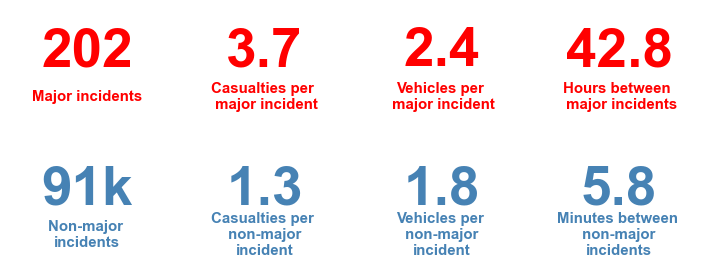

In [42]:
# Plot text values of main stats
plt.style.use('seaborn-white')
fig, ax = plt.subplots(2, 4, figsize=(10,4))
ax = ax.ravel()
m = 0
n = m+4

for value, text in zip(major_val, major_text):
    plot_text_(value, text, 'major', ax[m])
    m += 1

for value, text in zip(non_major_val, non_major_text):
    plot_text_(value, text, 'non_major', ax[m])
    m += 1

### Major incidents are 3 times deadlier than the others

Major incidents are comparatively rarer than other accidents, occurring roughly once every other day. Hence, they represent a tiny fraction (less than 1%) of all 91,185 accidents recorded in 2020. But they cause three times as many deaths per accident as all non-major incidents combined. 

Also, on average, major incidents involve 30% more vehicles per accident than all other accidents.


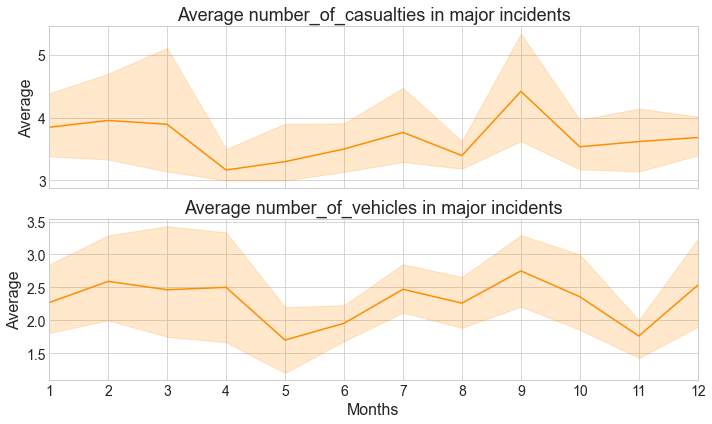

In [43]:
# Plot average casualties and vehicles per month in major incidents
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(2, 1, figsize=(10,6), sharex=True)

plot_avg_month_(major_incidents, 'number_of_casualties', 'major', ax[0])
plot_avg_month_(major_incidents, 'number_of_vehicles', 'major', ax[1])

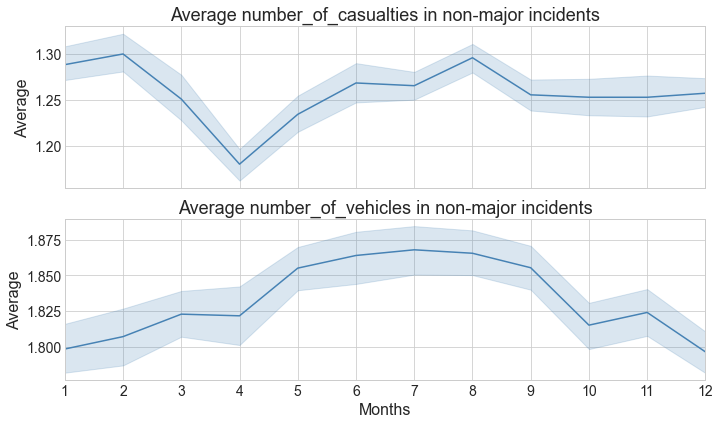

In [30]:
# Plot average casualties and vehicles per month in non-major incidents
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(2, 1, figsize=(10,6), sharex=True)

plot_avg_month_(non_major_incidents, 'number_of_casualties', 'non_major', ax[0])
plot_avg_month_(non_major_incidents, 'number_of_vehicles', 'non_major', ax[1])

The number of casualties and vehicles per accident is various. However, by plotting these averages and their 95% confidence intervals, as shown in the graphs below (where the 95% confidence interval is represented by the shaded area), we can get a sense of how much these averages are likely to vary if we were to record accidents again and again.

From this, we can see that the average number of casualties caused by major incidents varies from non-major incidents not only in magnitude but also in variability. When compared to non-major incidents, the level of destruction caused by major incidents appears to vary significantly more from month to month.

In view of this high and volatile fatality rate, no effort should be considered too big to bring down this number

### Major incidents frequent single carriageways in rural areas
A pattern can be clearly seen in the map below. Whereas non-major incidents seem to be distributed throughout much of the United Kingdom, major incidents seem to cluster in roads connecting major urban centers like London, Birmingham, and Manchester with coast side locations and other rural areas.

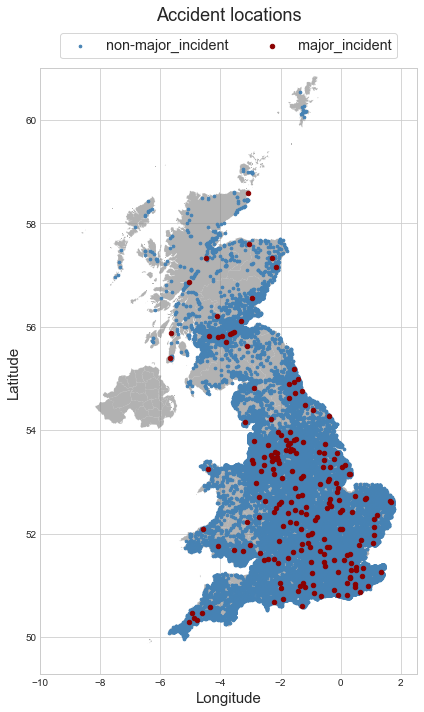

In [39]:
# Plot map and locations of accidents
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(figsize=(10,10))

plot_map_(r'M:/RoadSafety/GBR_adm2.shp', accidents, ax)

The graph below packs a lot of information, displayed on two levels:

-	The horizontal bars show the proportion of major incidents (in red) occurring per type of area, compared to the proportion of non-major incidents (in blue) in the same type of area 
-	The bubbles to the right of the bars show the proportion of casualties caused by major incidents only in each type of area

From this visualization, we can conclude that our killer seems to focus its attacks in rural areas rather than big cities.


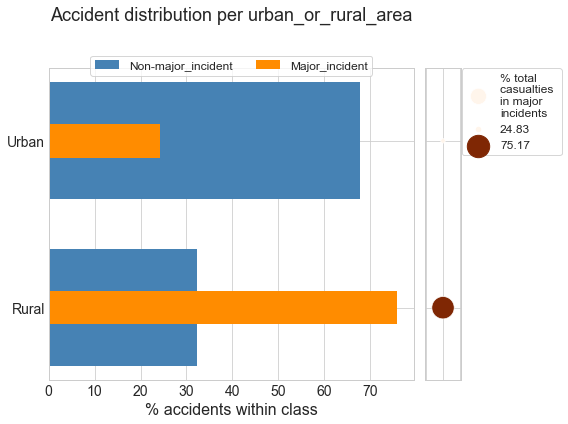

In [44]:
# Plot distribution of accidents and casualties per urban or rural areas
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(1, 2, figsize=(8,6), sharey=True, \
                       gridspec_kw=dict(width_ratios=[3, 0.3]))

plot_bullets_('urban_or_rural_area', ax[0], ax[1])

Likewise, from similar graphs based on road-related features, we can ascertain that major incidents seem to be concentrated in type A single carriageways, with neither secondary roads involved, nor junctions or pedestrian crossings. 

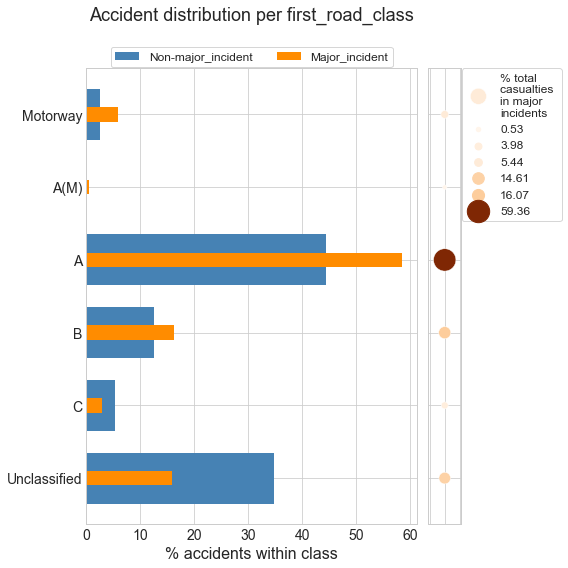

In [45]:
# Plot distribution of accidents and casualties per first road class
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(1, 2, figsize=(8,8), sharey=True, \
                       gridspec_kw=dict(width_ratios=[3, 0.3]))

plot_bullets_('first_road_class', ax[0], ax[1])

### Major incidents peak in late summer, weekends, and late afternoons
July, August, and December seem to concentrate a larger proportion of major incidents than non-major incidents (roughly 35% of the total). This could be possibly tied to holiday/downtime travel for many people wanting to visit other parts of the country.

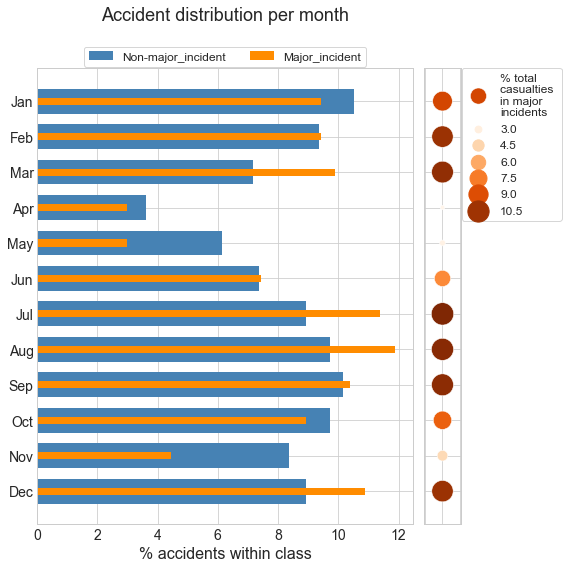

In [46]:
# Plot distribution of accidents and casualties per month
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(1, 2, figsize=(8,8), sharey=True, \
                       gridspec_kw=dict(width_ratios=[3, 0.3]))

plot_bullets_('month', ax[0], ax[1])

When our focus is narrowed to days of the week, this initial hunch about holiday/leisure travel seems to be further reinforced by the fact that about a quarter of major incidents occurs on Saturdays, followed by Thursdays and Sundays.

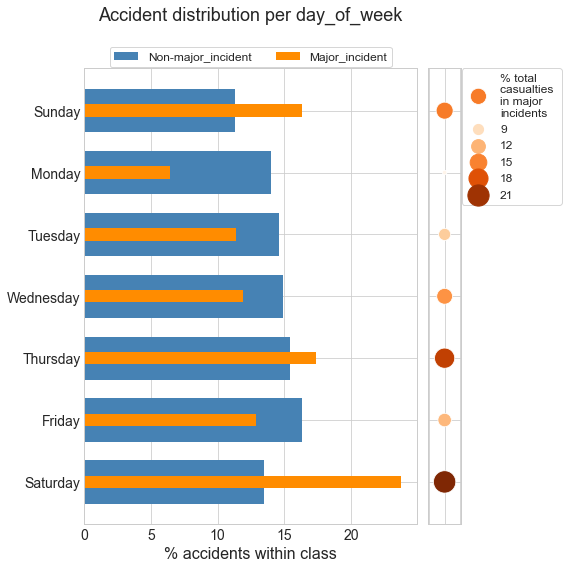

In [47]:
# Plot distribution of accidents and casualties per day of week
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(1, 2, figsize=(8,8), sharey=True, \
                       gridspec_kw=dict(width_ratios=[3, 0.3]))

plot_bullets_('day_of_week', ax[0], ax[1])

Major incidents are more likely to occur in the period between 6 pm and 6 am than non-major incidents. However, major incidents are more frequent and hence deadlier in the range from **5pm** to **6pm**, followed by 10 pm.

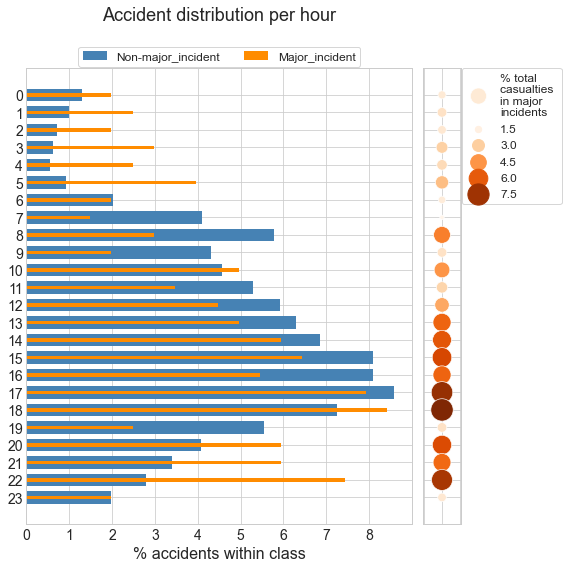

In [48]:
# Plot distribution of accidents and casualties per hour of day
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(1, 2, figsize=(8,8), sharey=True, \
                       gridspec_kw=dict(width_ratios=[3, 0.3]))

plot_bullets_('hour', ax[0], ax[1])

### Major incidents strike in broad daylight, fine weather, and at **60-mph** limits
Like non-major incidents, the vast majority of major incidents seem to occur in daylight and fine weather. However, it is important to note that major incidents are 4 times more likely to occur in darkness than non-major incidents, though the overall proportion is still low (roughly 20%). 

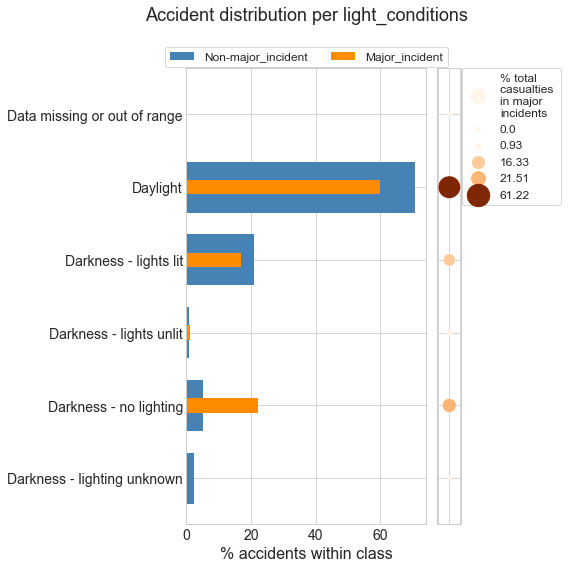

In [49]:
# Plot distribution of accidents and casualties per light conditions
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(1, 2, figsize=(8,8), sharey=True, \
                       gridspec_kw=dict(width_ratios=[3, 0.3]))

plot_bullets_('light_conditions', ax[0], ax[1])

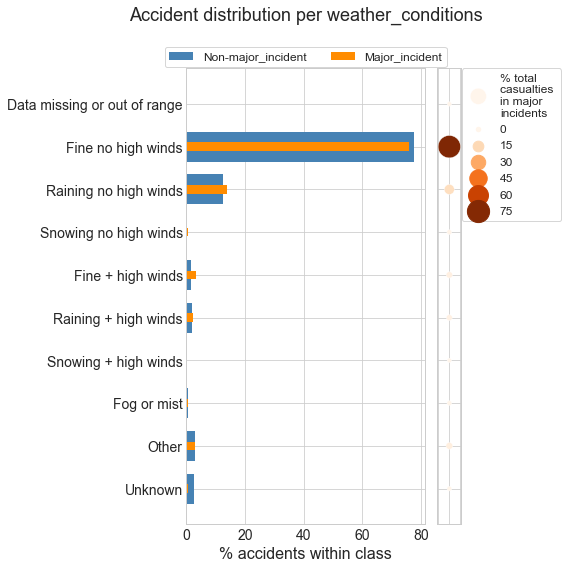

In [50]:
# Plot distribution of accidents and casualties per weather conditions
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(1, 2, figsize=(8,8), sharey=True, \
                       gridspec_kw=dict(width_ratios=[3, 0.3]))

plot_bullets_('weather_conditions', ax[0], ax[1])

Also, major incidents are markedly more frequent in roads with a **60-mph** speed limit.

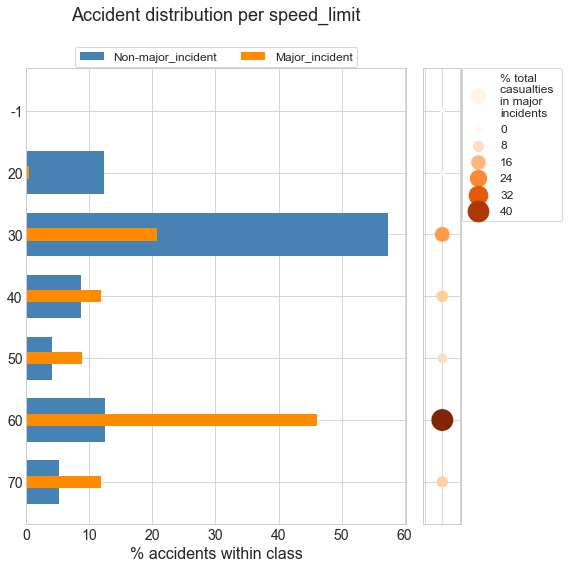

In [51]:
# Plot distribution of accidents and casualties per speed limits
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(1, 2, figsize=(8,8), sharey=True, \
                       gridspec_kw=dict(width_ratios=[3, 0.3]))

plot_bullets_('speed_limit', ax[0], ax[1])

Similarly, though the majority of non-major and major incidents occur on dry road surfaces, major incidents are comparatively more likely to occur on wet roads. No special hazards or conditions are generally observed in major incidents.

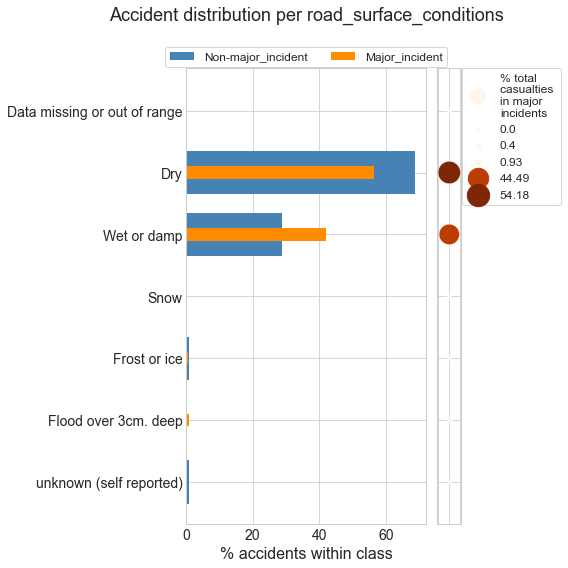

In [52]:
# Plot distribution of accidents and casualties per road surface conditions
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(1, 2, figsize=(8,8), sharey=True, \
                       gridspec_kw=dict(width_ratios=[3, 0.3]))

plot_bullets_('road_surface_conditions', ax[0], ax[1])

### Finding the deadliest hour
In general, major incidents don't seem to be brought on by "external" factors like weather, lighting, and road conditions. Instead, they could be possibly linked to other causes not recorded in the data, such as speeding, driver impairment, etc.

But, what about the periods with most major incidents? Does this pattern persist in that case? Our **second objective** is now two-parts:
    
-   Identify the specific day of the week and hour of the day when most major incidents occur.
-	Take note of any trends on this day and time that might not match the general description of our killer.

*Note: for the sake of brevity, only the most relevant graphs will be shown in this section. The full list of graphs used during the analysis can be found in the appendix of this report.*

### Saturday at **10pm** is the deadliest time
In the previous section, we had seen that Saturdays are by far the deadliest day of the week. 
Looking closer at the distribution of major incidents by hour of day on Saturdays, we can see that almost 1/8 of casualties occur at 10 pm, clearly indicating that this is the deadliest hour on the deadliest day of the week.

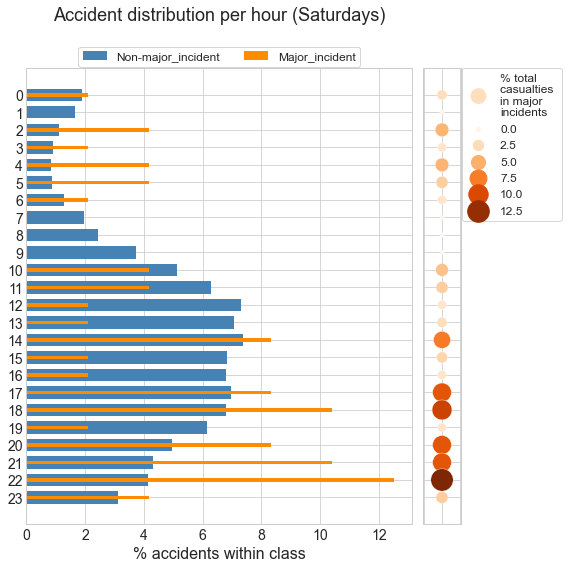

In [53]:
# Plot distribution of accidents and casualties per hour on Saturdays
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(1, 2, figsize=(8,8), sharey=True, \
                       gridspec_kw=dict(width_ratios=[3, 0.3]))

saturdays = accidents[accidents['day_of_week']==7]
plot_bullets_('hour', ax[0], ax[1], saturdays, text=' (Saturdays)')

The incidents at this deadliest time seem to be sparsely distributed in an area extending from Newcastle Upon Tyne in the north till Southampton in the south, mostly focused in coastal areas, as shown below.

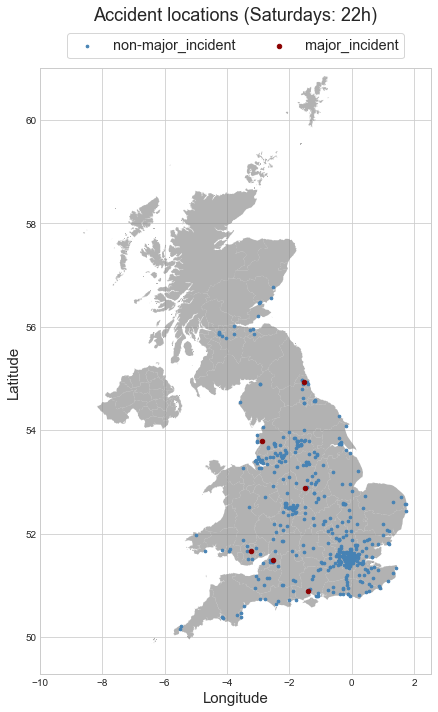

In [55]:
# Plot map and locations of accidents on Saturdays at 22h
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(figsize=(10,10))
saturdays_22h = accidents[(accidents['day_of_week']==7)&(accidents['hour']==22)]
plot_map_(r'M:/RoadSafety/GBR_adm2.shp', saturdays_22h, ax, text=' (Saturdays: 22h)')

### Major incidents at the deadliest time are more influenced by external conditions
Major incidents occurring on Saturdays at 10 pm are not only the deadliest killer by sheer numbers, but they also seem to follow unique patterns that differ from other major incidents as well as all non-major incidents.

For instance, roughly 35% of these accidents occur in urban areas, compared to just a quarter of all major incidents in general.

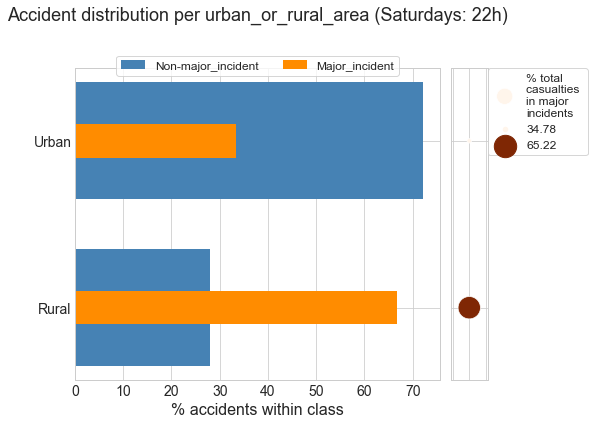

In [56]:
# Plot distribution of accidents and casualties per area on Saturdays at 22h
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(1, 2, figsize=(8,6), sharey=True, \
                       gridspec_kw=dict(width_ratios=[3, 0.3]))

saturdays_22h = accidents[(accidents['day_of_week']==7)&(accidents['hour']==22)]
plot_bullets_('urban_or_rural_area', ax[0], ax[1], saturdays_22h, ' (Saturdays: 22h)')

Accidents on Saturday at 10 pm seem to be equally distributed between Motorways, Type A, and type C roads. We also observe an increase in the presence of T or staggered junctions (50% of incidents), and dual carriageways (35% of incidents). 

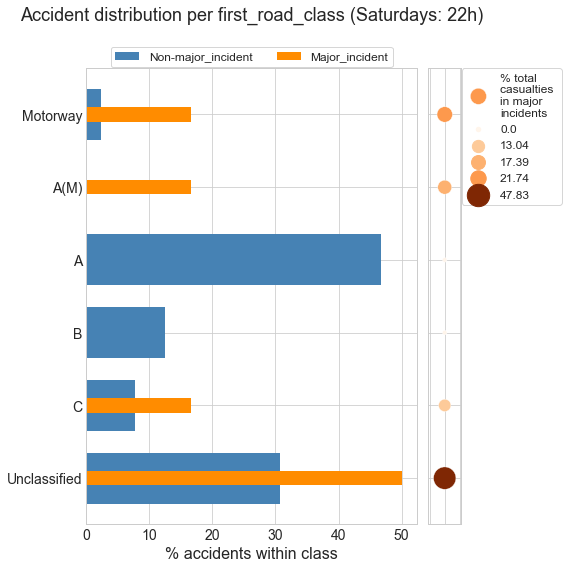

In [57]:
# Plot distribution of accidents and casualties per first road class on Saturdays at 22h
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(1, 2, figsize=(8,8), sharey=True, \
                       gridspec_kw=dict(width_ratios=[3, 0.3]))

saturdays_22h = accidents[(accidents['day_of_week']==7)&(accidents['hour']==22)]
plot_bullets_('first_road_class', ax[0], ax[1], saturdays_22h, ' (Saturdays: 22h)')

Also, major incidents on Saturdays at **10 pm** seem to be equally frequent in roads with a 70-mph and a 40-mph speed limit.

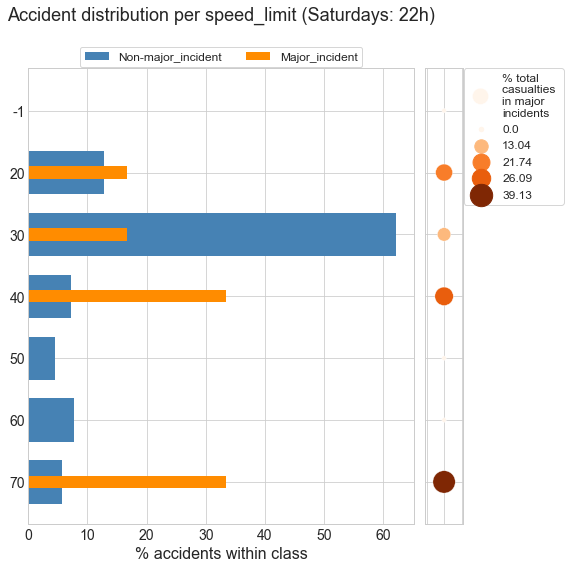

In [58]:
# Plot distribution of accidents and casualties per speed limit on Saturdays at 22h
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(1, 2, figsize=(8,8), sharey=True, \
                       gridspec_kw=dict(width_ratios=[3, 0.3]))

saturdays_22h = accidents[(accidents['day_of_week']==7)&(accidents['hour']==22)]
plot_bullets_('speed_limit', ax[0], ax[1], saturdays_22h, ' (Saturdays: 22h)')

Roughly **80%** of these accidents occur in darkness (50% with lights lit, 35% no lighting), 50% occur in raining conditions, and a staggering 86% occur on wet roads.

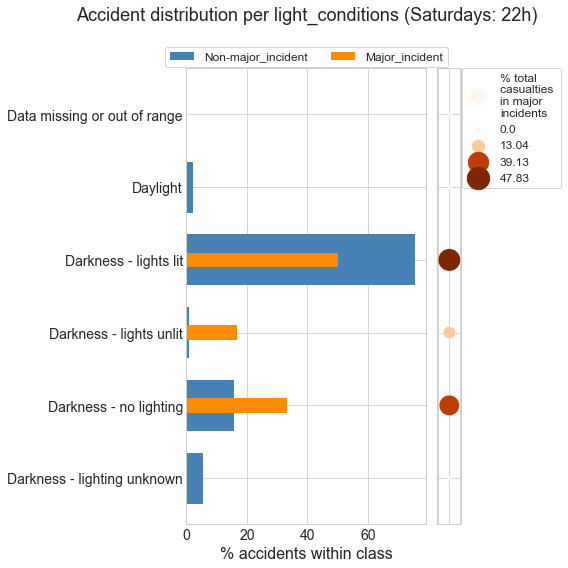

In [59]:
# Plot distribution of accidents and casualties per light conditions on Saturdays at 22h
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(1, 2, figsize=(8,8), sharey=True, \
                       gridspec_kw=dict(width_ratios=[3, 0.3]))

saturdays_22h = accidents[(accidents['day_of_week']==7)&(accidents['hour']==22)]
plot_bullets_('light_conditions', ax[0], ax[1], saturdays_22h, ' (Saturdays: 22h)')

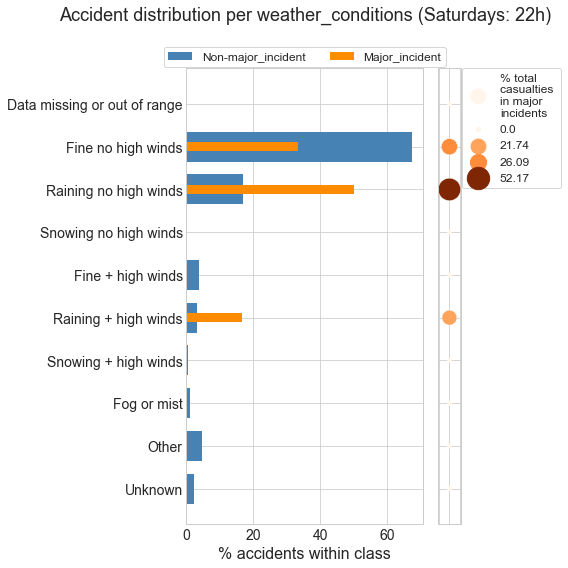

In [60]:
# Plot distribution of accidents and casualties per weather conditions on Saturdays at 22h
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(1, 2, figsize=(8,8), sharey=True, \
                       gridspec_kw=dict(width_ratios=[3, 0.3]))

saturdays_22h = accidents[(accidents['day_of_week']==7)&(accidents['hour']==22)]
plot_bullets_('weather_conditions', ax[0], ax[1], saturdays_22h, ' (Saturdays: 22h)')

All these patterns seem to indicate that, unlike major incidents in general, the accidents occurring at the deadliest time are heavily influenced by external factors like bad weather, dim lighting, and poor road surface conditions.

## Staying one step ahead
So far, we have some points about major incidents:

-	are 3 times deadlier than all other accidents
-	frequent single carriageways in rural areas
-	peak in late summer, weekends, and late afternoons
-	strike in broad daylight, fine weather, and at 60-mph limits

When looking at the day of week and time of day when most major incidents occur, we have determined that:

-	Saturday at 10pm is the deadliest time by sheer number of accidents and casualties
-	Major incidents occurring at this time are more influenced by external conditions

In addition, we have also shown that:

-	Location and time are the most important predictors of major incidents


Our **final objective** is now to offer recommendations that could help the planning team reduce major incidents. 


## Recommendations
We have seen that major incidents in 2020 do not seem to be significantly influenced by external factors like weather, lighting, and road conditions, but perhaps other *“behavioural”* conditions not recorded in the data, driver impairment, driver experience/skill, etc. The seasonality of the events in general seems to point in this direction.

We have also seen that the periods with the highest concentration of major incidents (i.e., Saturdays at 10 pm) reveal a different pattern, where external factors play a bigger role.  

Therefore, the task of stopping major incidents should be approached with a two-pronged strategy aiming to address both *behavioural* and *external factors* involved in major incidents. Our strategy should consider the following actions:

-   Extend the analysis of accident data, in order to establish the variability of findings and confirm accident predictors and conditions 
-   Analyze accident data an ongoing task, by incorporating the graphs used in this report into dashboards and other visualization tools
-   Include *behavioural* factors like driver impairment, driver experience, car conditions, etc., in the accident data
-   Counteract *behavioural* factors by increasing awareness of drivers about major incidents, and their general seasonal patterns, through institutional ad campaigns and educational materials
-   Minimize potentially hazardous external conditions like poor lighting, lack of junction controls, dual carriageways, etc., by allocating resources (e.g., human, or automated control) at specific known locations and times of the deadliest major incidents 

## Appendix
This section lists all graphs that were part of the analysis, but not were not included in the main text of the report for the sake of brevity.

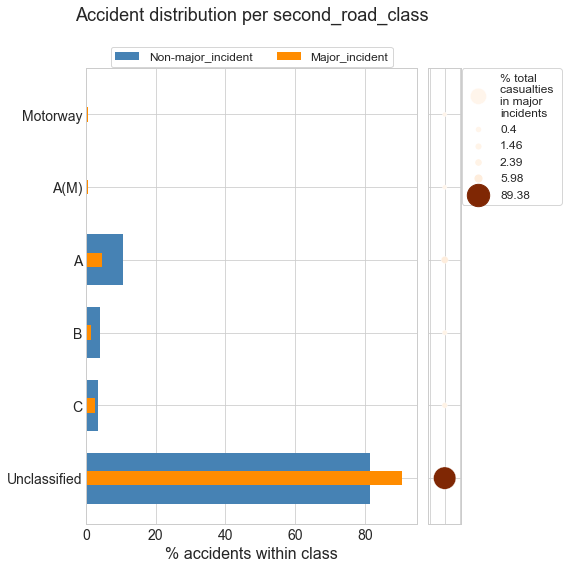

In [62]:
# Plot distribution of accidents and casualties per second road class
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(1, 2, figsize=(8,8), sharey=True, \
                       gridspec_kw=dict(width_ratios=[3, 0.3]))

plot_bullets_('second_road_class', ax[0], ax[1])

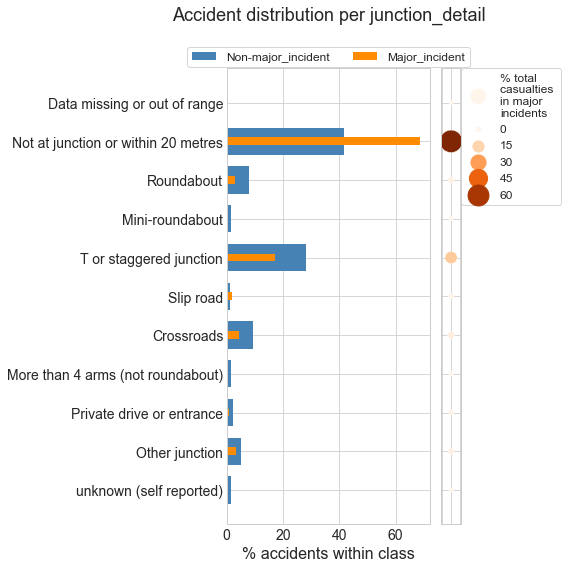

In [64]:
# Plot distribution of accidents and casualties per juntion detail
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(1, 2, figsize=(8,8), sharey=True, \
                       gridspec_kw=dict(width_ratios=[3, 0.3]))

plot_bullets_('junction_detail', ax[0], ax[1])

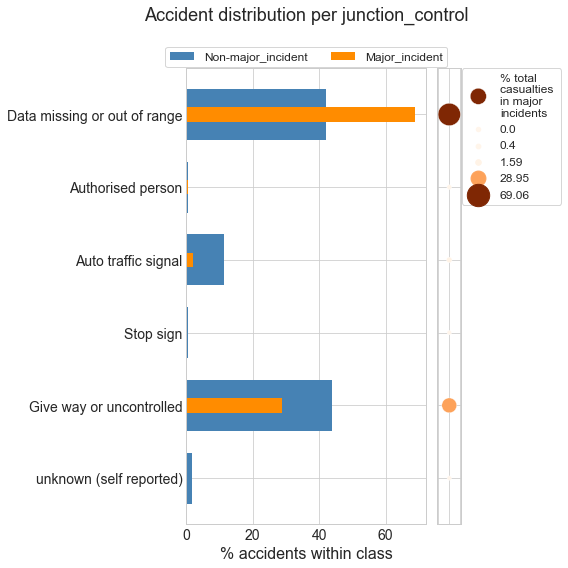

In [65]:
# Plot distribution of accidents and casualties per juntion control
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(1, 2, figsize=(8,8), sharey=True, \
                       gridspec_kw=dict(width_ratios=[3, 0.3]))

plot_bullets_('junction_control', ax[0], ax[1])

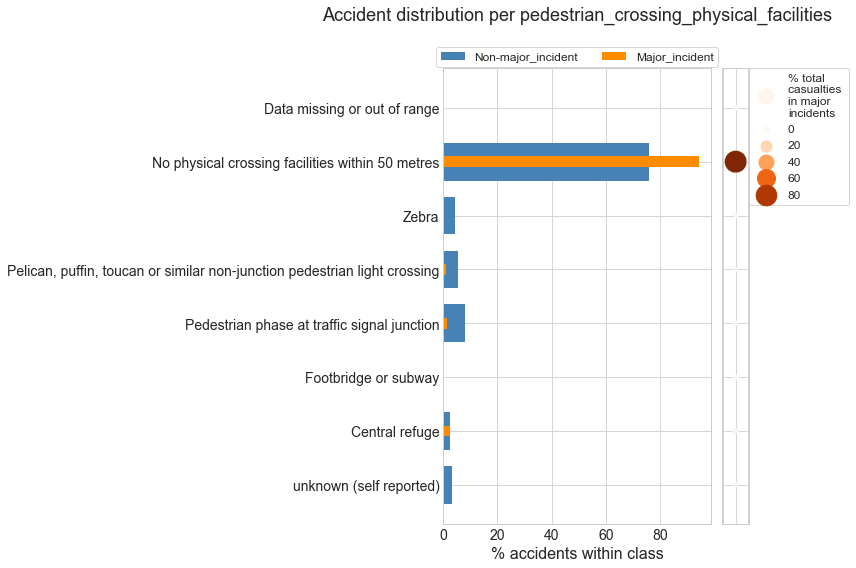

In [66]:
# Plot distribution of accidents and casualties per pedestrian crossing
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(1, 2, figsize=(12,8), sharey=True, \
                       gridspec_kw=dict(width_ratios=[3, 0.3]))

plot_bullets_('pedestrian_crossing_physical_facilities', ax[0], ax[1])

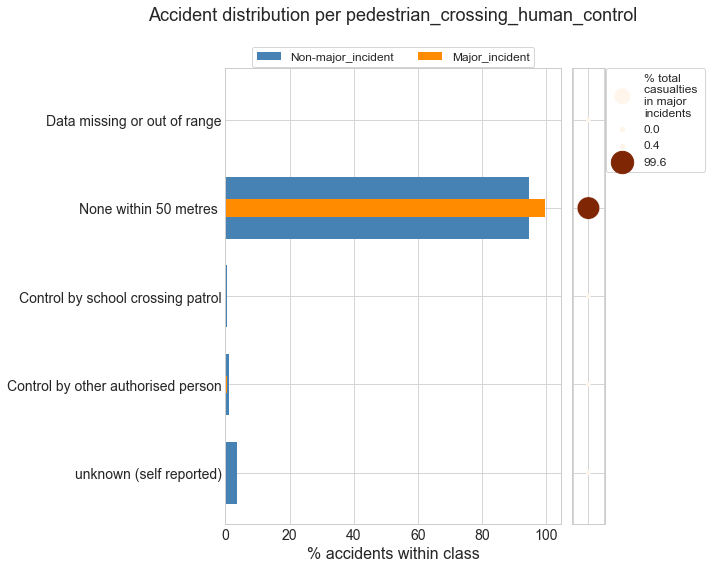

In [67]:
# Plot distribution of accidents and casualties per pedestrian control
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(1, 2, figsize=(10,8), sharey=True, \
                       gridspec_kw=dict(width_ratios=[3, 0.3]))

plot_bullets_('pedestrian_crossing_human_control', ax[0], ax[1])

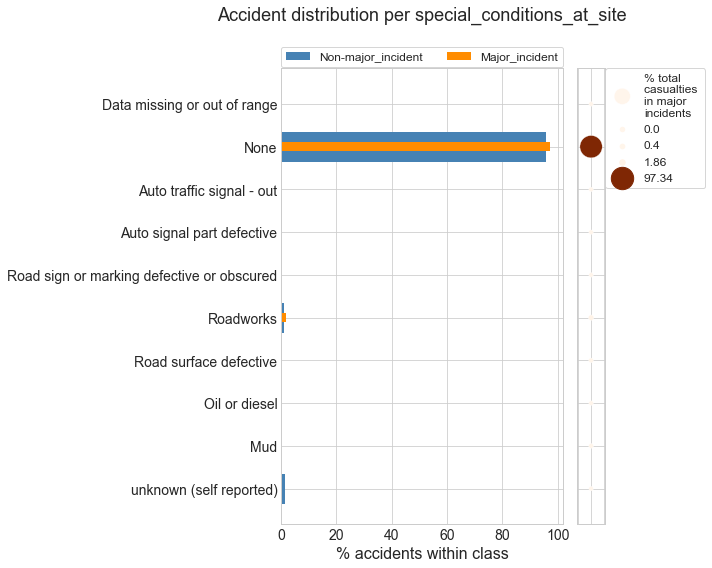

In [68]:
# Plot distribution of accidents and casualties per special conditions at site
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(1, 2, figsize=(10,8), sharey=True, \
                       gridspec_kw=dict(width_ratios=[3, 0.3]))

plot_bullets_('special_conditions_at_site', ax[0], ax[1])

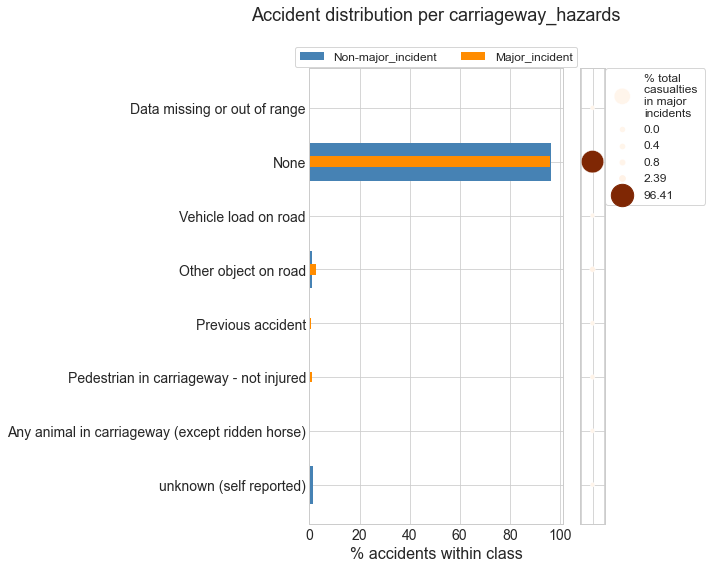

In [69]:
# Plot distribution of accidents and casualties per carriageway hazards
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(1, 2, figsize=(10,8), sharey=True, \
                       gridspec_kw=dict(width_ratios=[3, 0.3]))

plot_bullets_('carriageway_hazards', ax[0], ax[1])

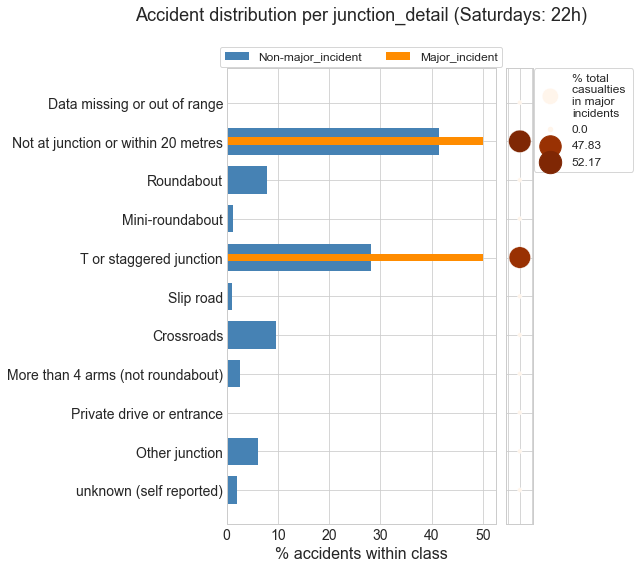

In [70]:
# Plot distribution of accidents and casualties per juntion detail on Saturdays at 22h
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(1, 2, figsize=(9,8), sharey=True, \
                       gridspec_kw=dict(width_ratios=[3, 0.3]))

saturdays_22h = accidents[(accidents['day_of_week']==7)&(accidents['hour']==22)]
plot_bullets_('junction_detail', ax[0], ax[1], saturdays_22h, ' (Saturdays: 22h)')

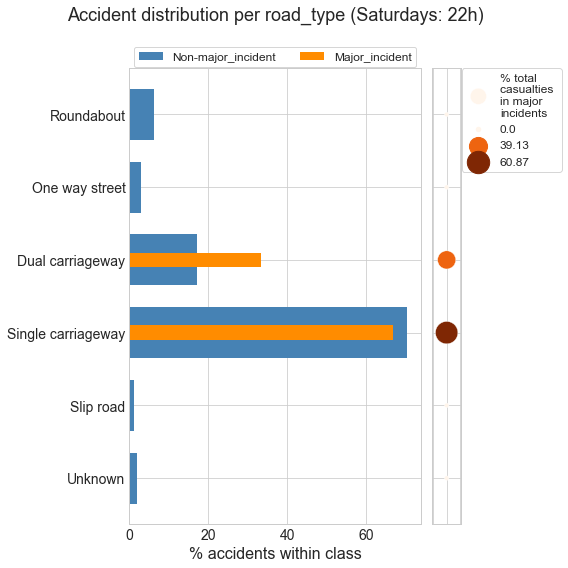

In [71]:
# Plot distribution of accidents and casualties per road type on Saturdays at 22h
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(1, 2, figsize=(8,8), sharey=True, \
                       gridspec_kw=dict(width_ratios=[3, 0.3]))

saturdays_22h = accidents[(accidents['day_of_week']==7)&(accidents['hour']==22)]
plot_bullets_('road_type', ax[0], ax[1], saturdays_22h, ' (Saturdays: 22h)')

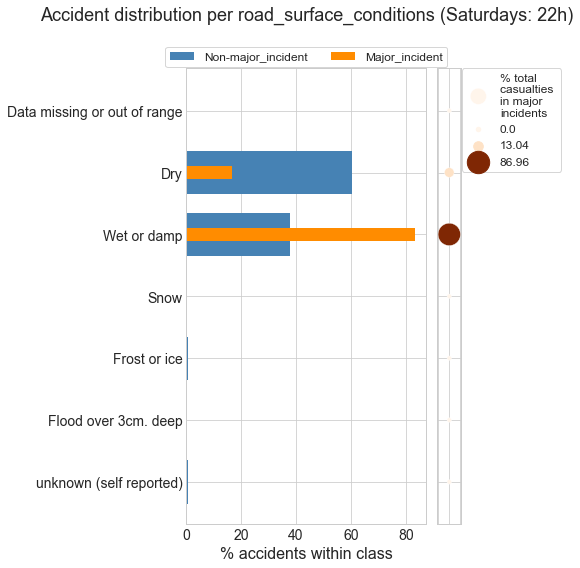

In [72]:
# Plot distribution of accidents and casualties per road surface conditions on Saturdays at 22h
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(1, 2, figsize=(8,8), sharey=True, \
                       gridspec_kw=dict(width_ratios=[3, 0.3]))

saturdays_22h = accidents[(accidents['day_of_week']==7)&(accidents['hour']==22)]
plot_bullets_('road_surface_conditions', ax[0], ax[1], saturdays_22h, ' (Saturdays: 22h)')